# Experiments on stock prize forecasting
## Sabrina Guastavino, guastavino@dima.unige.it

In [1]:
import os
import csv
import numpy as np
import random
import pandas
import pickle
import glob
import os.path
import sys

import matplotlib
import matplotlib.pyplot as plt
from keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger

import time
import os.path
import numpy

from sklearn.metrics import confusion_matrix


import keras
import numpy
from keras.layers import Dense, Flatten, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential, load_model
from keras.optimizers import Adam, RMSprop, SGD


from keras.models import Model
from keras.models import Input



from tensorflow.keras import regularizers

from keras.layers import Activation
from sklearn.metrics import confusion_matrix


from keras import backend as K
import tensorflow as tf



from collections import deque
import sys
import matplotlib.pyplot as plt

import datetime
import numpy as np
import pandas as pd
import sklearn

from pandas_datareader import data, wb

from sklearn.linear_model import LogisticRegression

import fix_yahoo_finance as yf



/home/sabry/.local/lib/python3.6/site-packages/fix_yahoo_finance/__init__.py:0: DeprecationWarning: 

*** `fix_yahoo_finance` was renamed to `yfinance`. ***
Please install and use `yfinance` directly using `pip install yfinance -U`

More information: https://github.com/ranaroussi/yfinance



In [2]:
from utilities.utilities_finance import training_set_standardization, testing_set_standardization, compute_cm_tss,\
optimize_threshold_skill_scores_weight_matrix, optimize_threshold_skill_scores,compute_cm_tss_acc,compute_weight_cm_tss_acc,\
compute_gain_seq,predict_ensemble,select_best_patience_on_val,predict,compute_weight_cm_tss,compute_cm_tss_threshold


## Data set

In [3]:
#load yahoo finance data
symbol="^GSPC"
start_date=datetime.datetime(2001,1,10)
end_date=datetime.datetime(2010,12,31) 
lags=5
ts = yf.download(symbol, start=start_date-datetime.timedelta(days=365), end=end_date)
ts

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2000-01-10,1441.469971,1464.359985,1441.469971,1457.599976,1457.599976,1064800000
2000-01-11,1457.599976,1458.660034,1434.420044,1438.560059,1438.560059,1014000000
2000-01-12,1438.560059,1442.599976,1427.079956,1432.250000,1432.250000,974600000
2000-01-13,1432.250000,1454.199951,1432.250000,1449.680054,1449.680054,1030400000
2000-01-14,1449.680054,1473.000000,1449.680054,1465.150024,1465.150024,1085900000
...,...,...,...,...,...,...
2010-12-23,1257.530029,1258.589966,1254.050049,1256.770020,1256.770020,2515020000
2010-12-27,1254.660034,1258.430054,1251.479980,1257.540039,1257.540039,1992470000
2010-12-28,1259.099976,1259.900024,1256.219971,1258.510010,1258.510010,2478450000


In [4]:
#*** 
def create_lagged_series(symbol, start_date, end_date, lags=5):
    """This creates a pandas DataFrame that stores the percentage returns of the 
    adjusted closing value of a stock obtained from Yahoo Finance, along with 
    a number of lagged returns from the prior trading days (lags defaults to 5 days).
    Trading volume, as well as the Direction from the previous day, are also included."""

    # Obtain stock information from Yahoo Finance
    ts = yf.download(symbol, start=start_date-datetime.timedelta(days=365), end=end_date)
    # Create the new lagged DataFrame
    tslag = pd.DataFrame(index=ts.index)
    tslag["Today"] = ts["Adj Close"]
    tslag["Volume"] = ts["Volume"]

    # Create the shifted lag series of prior trading period close values
    for i in range(0,lags):
        tslag["Lag%s" % str(i+1)] = ts["Adj Close"].shift(i+1)

    # Create the returns DataFrame
    tsret = pd.DataFrame(index=tslag.index)
    tsret["Volume"] = tslag["Volume"]
    tsret["Today"] = tslag["Today"].pct_change()*100.0

    # If any of the values of percentage returns equal zero, set them to
    # a small number (stops issues with QDA model in scikit-learn)
    for i,x in enumerate(tsret["Today"]):
        if (abs(x) < 0.0001):
            tsret["Today"][i] = 0.0001

    # Create the lagged percentage returns columns
    for i in range(0,lags):
        tsret["Lag%s" % str(i+1)] = tslag["Lag%s" % str(i+1)].pct_change()*100.0

    # Create the "Direction" column (+1 or -1) indicating an up/down day
    tsret["Direction"] = np.sign(tsret["Today"])
    tsret = tsret[tsret.index >= start_date]

    return tsret

## Training, validation and test sets

In [5]:
##
snpret = create_lagged_series("^GSPC", datetime.datetime(2001,1,10), datetime.datetime(2011,1,1), lags=5)#

# Use the prior five days of returns as predictor values, with direction as the response
X = snpret[["Lag1","Lag2","Lag3","Lag4","Lag5"]] 
y = snpret["Today"]

threshold=-1
start_test = datetime.datetime(2009,11,25)

# Create training, validation and test sets

X_train_val = X[X.index < start_test]
y_train_val = y[y.index < start_test]
y_bin_train_val = y_train_val.values < threshold

# test
X_test = X[X.index >= start_test]
y_test = y[y.index >= start_test]
y_bin_test = y_test.values < threshold

# Create prediction DataFrame
pred = pd.DataFrame(index=y_test.index)
pred["Actual"] = y_test

y_train_val = 1*y_bin_train_val

y_test = 1*y_bin_test

perc_train_val=len(numpy.where(y_train_val==1)[0])*100/y_train_val.shape[0]

X_train = X_train_val[0:1728]
X_val=X_train_val[1728:]

y_train=y_train_val[0:1728]
y_val=y_train_val[1728:]
print('#YES in y_train:', len(numpy.where(y_train==True)[0]))
perc_train=len(numpy.where(y_train==1)[0])*100/y_train.shape[0]
print('#YES in y_val:', len(numpy.where(y_val==True)[0]))
perc_val=len(numpy.where(y_val==1)[0])*100/y_val.shape[0]
print('#YES in y_test:', len(numpy.where(y_bin_test==True)[0]))
perc_test=len(numpy.where(y_test==1)[0])*100/y_test.shape[0]

##standardization
X_train_val_std, mm, sd = training_set_standardization(X_train_val.values)
X_train_std = X_train_val_std[0:1728]
X_val_std = X_train_val_std[1728:]

X_test_std = testing_set_standardization(X_test.values, mm, sd)


##reshape X_train_std, X_val_std and X_test_std for the LSTM model
features=1
n_lags=5
train_X = X_train_std.reshape(X_train_std.shape[0], n_lags, features)
print('shape of training: ', train_X.shape)
val_X = X_val_std.reshape(X_val_std.shape[0], n_lags, features)
print('shape of validation: ', val_X.shape)
test_X = X_test_std.reshape((X_test_std.shape[0], n_lags, features))
print('shape of test: ', test_X.shape)

[*********************100%***********************]  1 of 1 completed
#YES in y_train: 240
#YES in y_val: 130
#YES in y_test: 41
shape of training:  (1728, 5, 1)
shape of validation:  (504, 5, 1)
shape of test:  (277, 5, 1)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


## Long Short Term Memory (LSTM) model

In [6]:
##model and training
from keras.regularizers import l2

run = False
save = False

model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2]),dropout=0.5,kernel_regularizer=l2(0.01)))#
model.add(Dense(1,activation='sigmoid'))
optimizer=Adam(lr=0.001)
model.compile(loss='binary_crossentropy', optimizer=optimizer)#temporal_binary_cross
model.summary()
if run == True:
    if save == True:
        checkpointer = ModelCheckpoint(
                filepath=os.path.join('prediction', 'checkpoints', 'lstm_5lags_dropout05_reg_l2_epoch100_LSTM50_train_to_2007_11_27_val_to_2009_11_24' \
                    '.{epoch:03d}-{val_loss:.3f}.hdf5'), 
                verbose=1,
                save_best_only=False)
    history = model.fit(train_X, y_train, epochs=100, batch_size=72, validation_data=(val_X, y_val), 
                        callbacks=[checkpointer],verbose=2, shuffle=False)
    # plot history
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='val')
    plt.legend()
    plt.show()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 50)                10400     
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 10,451
Trainable params: 10,451
Non-trainable params: 0
_________________________________________________________________


## Optimization strategy to select optimal thresholds along epochs

In [7]:
#computation of optimal thresholds on training by optimizing the tss and wtss 
from utilities.utilities_finance import compute_cm_tss_threshold,compute_weight_cm_tss_threshold
folder = 'prediction/checkpoints/'

list_epochs = sorted(glob.glob(folder+'lstm_5lags_epoch100_LSTM50_train_to_2007_11_27_val_to_2009_11_24*.hdf5'))
file_name = 'lstm_5lags_epoch100_LSTM50_train_to_2007_11_27_val_to_2009_11_24.npy'

if run == True:
    threshold_opt=[]
    tss_train_dict=[]
    tss_val_dict=[]


    threshold_opt_tss=[]
    threshold_opt_hss=[]



    tss_train_dict_opt_tss=[]
    tss_val_dict_opt_tss=[]
    hss_train_dict_opt_tss=[]
    hss_val_dict_opt_tss=[]


    threshold_opt_tss_weight=[]


    tss_train_dict_opt_tss_weight=[]
    tss_val_dict_opt_tss_weight=[]
    hss_train_dict_opt_tss_weight=[]
    hss_val_dict_opt_tss_weight=[]
    j=0
    for file in list_epochs:
        print(file)
        model = load_model(file,compile=False)
        pred_train = model.predict(train_X)
        pred_val = model.predict(val_X)
        pred_prob = pred_train.reshape(1,len(pred_train))
        pred_prob = pred_prob[0]
        pred_prob_val = pred_val.reshape(1,len(pred_val))
        pred_prob_val = pred_prob_val[0]

        #OPTIMIZE new TSS with weighted matrix
        threshold_nss_weight, metrics_training_weight, nss_vector_weight, threshold_tss_weight, threshold_hss_weight, \
                     threshold_tss_hss_weight, \
                          max_tss_hss_weight = optimize_threshold_skill_scores_weight_matrix(pred_prob, y_train)



        threshold_opt_tss_weight.append(threshold_tss_weight)


        #OPTIMIZE NSS
        #threshold, metrics_training, nss_vector = optimize_threshold_NSS(pred_prob, y_train)
        threshold_nss, metrics_training, nss_vector, threshold_tss, threshold_hss, \
                          threshold_tss_hss, max_tss_hss = optimize_threshold_skill_scores(pred_prob, y_train)


        threshold_opt_tss.append(threshold_tss)

        j = j + 1



        #best tss
        cm, tss, hss, csi  = compute_cm_tss_threshold(y_train, pred_prob,threshold_tss)
        tss_train_dict_opt_tss.append(tss)
        hss_train_dict_opt_tss.append(hss)
        cm_val, tss_val, hss_val, csi_val = compute_cm_tss_threshold(y_val, pred_prob_val,threshold_tss)
        tss_val_dict_opt_tss.append(tss_val)
        hss_val_dict_opt_tss.append(hss_val)
        print ('threshold best tss                 \t', threshold_tss)


        #best tss
        cm, tss, hss, csi  = compute_weight_cm_tss_threshold(y_train, pred_prob,threshold_tss_weight)
        tss_train_dict_opt_tss_weight.append(tss)
        hss_train_dict_opt_tss_weight.append(hss)
        cm_val, tss_val, hss_val, csi_val = compute_weight_cm_tss_threshold(y_val, pred_prob_val,threshold_tss_weight)
        tss_val_dict_opt_tss_weight.append(tss_val)
        hss_val_dict_opt_tss_weight.append(hss_val)
        print ('threshold best tss                 \t', threshold_tss_weight)



    if save == True:
        #save variables
        path_save_variable = 'utilities/save_variables/'
        file_tss_val_dict_tss = path_save_variable+'tss_val_optimize_TSS_'+file_name
        file_hss_val_dict_tss = path_save_variable+'hss_val_optimize_TSS_'+file_name

        file_tss_train_dict_tss = path_save_variable+'tss_train_optimize_TSS_'+file_name
        file_hss_train_dict_tss = path_save_variable+'hss_train_optimize_TSS_'+file_name

        file_threshold_dict_tss = path_save_variable+'thresholds_val_optimize_TSS_'+file_name

        numpy.save(file_tss_val_dict_tss, tss_val_dict_opt_tss)
        numpy.save(file_hss_val_dict_tss, hss_val_dict_opt_tss)

        numpy.save(file_tss_train_dict_tss, tss_train_dict_opt_tss)
        numpy.save(file_hss_train_dict_tss, hss_train_dict_opt_tss)

        numpy.save(file_threshold_dict_tss, threshold_opt_tss)



        ###########
        file_tss_val_dict_tss_weight = path_save_variable+'tss_val_weight_optimize_TSS_'+file_name
        file_hss_val_dict_tss_weight = path_save_variable+'hss_val_weight_optimize_TSS_'+file_name

        file_tss_train_dict_tss_weight = path_save_variable+'tss_train_weight_optimize_TSS_'+file_name
        file_hss_train_dict_tss_weight = path_save_variable+'hss_train_weight_optimize_TSS_'+file_name

        file_threshold_dict_tss_weight = path_save_variable+'thresholds_val_weight_optimize_TSS_'+file_name

        numpy.save(file_tss_val_dict_tss_weight, tss_val_dict_opt_tss_weight)
        numpy.save(file_hss_val_dict_tss_weight, hss_val_dict_opt_tss_weight)

        numpy.save(file_tss_train_dict_tss_weight, tss_train_dict_opt_tss_weight)
        numpy.save(file_hss_train_dict_tss_weight, hss_train_dict_opt_tss_weight)

        numpy.save(file_threshold_dict_tss_weight, threshold_opt_tss_weight)




In [8]:
#load the variables for the prediction with the ensemble strategy
path_save_variable = 'utilities/save_variables/'
file_name = 'lstm_5lags_epoch100_LSTM50_train_to_2007_11_27_val_to_2009_11_24.npy'
file_threshold_dict_tss = path_save_variable+'thresholds_val_optimize_TSS_'+file_name
thresholds=numpy.load(file_threshold_dict_tss)
file_name_w = 'lstm_5lags_epoch100_LSTM50_train_to_2007_11_27_val_to_2009_11_24.npy'
file_threshold_dict_tss_w = path_save_variable+'thresholds_val_weight_optimize_TSS_'+file_name
thresholds_w=numpy.load(file_threshold_dict_tss_w)

threshold_opt_tss_weight=thresholds_w
threshold_opt_tss=thresholds

file_name_tss = path_save_variable+'tss_val_optimize_TSS_'+file_name
file_name_wtss = path_save_variable+'tss_val_weight_optimize_TSS_'+file_name

tss_val_dict_opt_tss=numpy.load(file_name_tss)
tss_val_dict_opt_tss_weight=numpy.load(file_name_wtss)

## Predict on test set

In [9]:
# make prediction on test set with the ensemble method with the tss and wtss optimization startegies
folder = 'prediction/checkpoints/'

list_epochs = sorted(glob.glob(folder+'lstm_5lags_epoch100_LSTM50_train_to_2007_11_27_val_to_2009_11_24*.hdf5'))

perc = 0.95
pred_median_pred_0_1 = predict_ensemble(tss_val_dict_opt_tss,perc,list_epochs,test_X,threshold_opt_tss)
pred_median_pred_0_1_weight = predict_ensemble(tss_val_dict_opt_tss_weight,perc,list_epochs,test_X,threshold_opt_tss_weight)

if save == True:
    #save predictions
    numpy.save('prediction/y_pred_test_wtss.npy',pred_median_pred_0_1_weight)
    numpy.save('prediction/y_pred_test_tss.npy',pred_median_pred_0_1)

In [10]:
#load prediction
pred_median_pred_0_1_weight = numpy.load('prediction/y_pred_test_wtss.npy')
pred_median_pred_0_1 = numpy.load('prediction/y_pred_test_tss.npy')

## Results on test set

In [11]:
##Results on test set
print('Results on test set with ensemble method')
#skill scores on the test set obtained by using the wtss optimization strategy
cm_test, tss_test, hss_test, csi_test, acc_test = compute_cm_tss_acc(y_test, pred_median_pred_0_1_weight)
print('Skill scores with wtss optimization strategy')
print(cm_test)
print('tss = ','{:0.4f}'.format(tss_test))
print('hss = ','{:0.4f}'.format(hss_test))
print('csi = ','{:0.4f}'.format(csi_test))
print('acc = ','{:0.4f}'.format(acc_test))
#skill scores on the test set obtained by using the tss optimization strategy
cm_test, tss_test, hss_test, csi_test, acc_test = compute_cm_tss_acc(y_test, pred_median_pred_0_1)
print('Skill scores tss with tss optimization strategy')
print(cm_test)
print('tss = ','{:0.4f}'.format(tss_test))
print('hss = ','{:0.4f}'.format(hss_test))
print('csi = ','{:0.4f}'.format(csi_test))
print('acc = ','{:0.4f}'.format(acc_test))

#value-weighted skill scores on the test set obtained by using the wtss optimization strategy
wcm_test, wtss_test, whss_test, wcsi_test, wacc_test = compute_weight_cm_tss_acc(y_test, pred_median_pred_0_1_weight)
print('Value-weighted skill scores with wtss optimization strategy')
print(wcm_test)
print('tss = ','{:0.4f}'.format(wtss_test))
print('hss = ','{:0.4f}'.format(whss_test))
print('csi = ','{:0.4f}'.format(wcsi_test))
print('acc = ','{:0.4f}'.format(wacc_test))
#value-weighted skill scores on the test set obtained by using the tss optimization strategy
wcm_test, wtss_test, whss_test, wcsi_test, wacc_test = compute_weight_cm_tss_acc(y_test, pred_median_pred_0_1)
print('Value-weighted skill scores with tss optimization strategy')
print(wcm_test)
print('tss = ','{:0.4f}'.format(wtss_test))
print('hss = ','{:0.4f}'.format(whss_test))
print('csi = ','{:0.4f}'.format(wcsi_test))
print('acc = ','{:0.4f}'.format(wacc_test))

Results on test set with ensemble method
Skill scores with wtss optimization strategy
[[166  70]
 [ 21  20]]
tss =  0.1912
hss =  0.1280
csi =  0.1802
acc =  0.6715
Skill scores tss with tss optimization strategy
[[158  78]
 [ 19  22]]
tss =  0.2061
hss =  0.1292
csi =  0.1849
acc =  0.6498
Value-weighted skill scores with wtss optimization strategy
[[166.          62.33333333]
 [ 17.41666667  20.        ]]
tss =  0.2615
hss =  0.1741
csi =  0.2005
acc =  0.6999
Value-weighted skill scores with tss optimization strategy
[[158.          71.83333333]
 [ 17.          22.        ]]
tss =  0.2516
hss =  0.1588
csi =  0.1985
acc =  0.6696


## Compute the gain

In [12]:
#
symbol="^GSPC"
start_date=datetime.datetime(2001,1,10)
#end_date=datetime.datetime(2005,12,31) 
end_date=datetime.datetime(2010,12,31) 
lags=5
ts_tot = yf.download(symbol, start=start_date-datetime.timedelta(days=365), end=end_date+datetime.timedelta(days=10))

tslag = pd.DataFrame(index=ts_tot.index)
tslag["Today"] = ts_tot["Adj Close"]
tslag["Volume"] = ts_tot["Volume"]

    # Create the shifted lag series of prior trading period close values
for i in range(0,lags):
    tslag["Lag%s" % str(i+1)] = ts["Adj Close"].shift(i+1)

# Create the returns DataFrame
tsret = pd.DataFrame(index=tslag.index)
tsret["Volume"] = tslag["Volume"]
tsret["Today"] = tslag["Today"]#.pct_change()*100.0


# Create the lagged percentage returns columns
for i in range(0,lags):
    tsret["Lag%s" % str(i+1)] = tslag["Lag%s" % str(i+1)]#.pct_change()*100.0

    
    
snpret_tot = create_lagged_series("^GSPC", datetime.datetime(2001,1,10), datetime.datetime(2011,1,10), lags=5)

snpret_tot=snpret_tot[snpret_tot.index >= start_test]
snpret_tot=snpret_tot[snpret_tot.index < end_date+datetime.timedelta(days=6) ]

Lag1_prize = tsret[["Lag1","Today"]]
Lag1_prize_test = Lag1_prize[Lag1_prize.index >= start_test]
Lag1_prize_test = Lag1_prize_test[Lag1_prize_test.index < end_date+datetime.timedelta(days=6) ]

#compute the indexes in which the prediction is 1
idx_1_weight=numpy.where(pred_median_pred_0_1_weight==1)[0]
idx_1=numpy.where(pred_median_pred_0_1==1)[0]

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [13]:
#***
threshold=-1
money,N_action, correct,anticipated_1day,anticipated_2day,over3,money_seq,N_action_seq,value_seq=compute_gain_seq(y_test,idx_1,Lag1_prize_test,snpret_tot,threshold)
print('money:',money)
print('actions:',N_action)
print('#correct=',correct)
print('#anticipated_1day=',anticipated_1day)
print('#anticipated_2day=',anticipated_2day)
print('#over3=',over3)
money_seq[260:]=money_seq[259]*numpy.ones(len(money_seq)-260)#numpy.ones(280-260)
N_action_seq[260:]=N_action_seq[259]*numpy.ones(len(money_seq)-260)#numpy.ones(280-260)
prizes=[Lag1_prize_test.values[ii][0] for ii in range(len(Lag1_prize_test))]
prizes_today=[Lag1_prize_test.values[ii][1] for ii in range(len(Lag1_prize_test))]
value_seq[260:]=N_action_seq[260:]*prizes[260:]+money_seq[260:]
value_seq_old=value_seq
value_seq=N_action_seq*prizes+money_seq
value_seq_closure=N_action_seq*prizes_today+money_seq

money: 716.1600341796875
actions: 9.0
#correct= 22
#anticipated_1day= 19
#anticipated_2day= 14
#over3= 45


In [14]:
#***
threshold=-1
money_weight,N_action_weight, correct_w,anticipated_1day_w,anticipated_2day_w,\
                                         over3_w,money_seq_w,N_action_seq_w,value_seq_w=compute_gain_seq(y_test,\
                                                                                                    idx_1_weight,Lag1_prize_test,\
                                                                                                  snpret_tot,threshold)
print('money:',money_weight)
print('actions:',N_action_weight)
print('#correct=',correct_w)
print('#anticipated_1day=',anticipated_1day_w)
print('#anticipated_2day=',anticipated_2day_w)
print('#over3=',over3_w)
#print(Lag1_prize_val)
money_seq_w[260:]=money_seq_w[259]*numpy.ones(len(money_seq_w)-260)#numpy.ones(280-260)
N_action_seq_w[260:]=N_action_seq_w[259]*numpy.ones(len(money_seq_w)-260)#numpy.ones(280-260)
prizes=[Lag1_prize_test.values[ii][0] for ii in range(len(Lag1_prize_test))]
prizes_today=[Lag1_prize_test.values[ii][1] for ii in range(len(Lag1_prize_test))]
value_seq_w[260:]=N_action_seq_w[260:]*prizes[260:]+money_seq_w[260:]
value_seq_old_w=value_seq_w
value_seq_w=N_action_seq_w*prizes+money_seq_w
value_seq_closure_w=N_action_seq_w*prizes_today+money_seq_w

money: 794.89990234375
actions: 9.0
#correct= 20
#anticipated_1day= 18
#anticipated_2day= 11
#over3= 41


## Plot

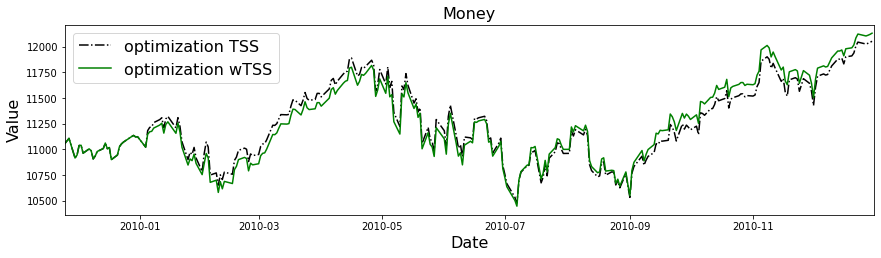

In [15]:
#FIGURE TO DO: JUST ALARMS IN TIME
import pandas as pd


import datetime as dt
dates=Lag1_prize_test.index
dates=[date for date in dates]


fig = plt.figure()
ax = fig.gca()
plt.title('Money', fontsize=16)


actions_plot_w = ax.plot(dates,value_seq,'k-.')
actions_plot = ax.plot(dates,value_seq_w,color='g')

ax.xaxis_date()
ax.set_ylabel('Value', fontsize=16)
ax.set_xlabel('Date', fontsize=16)
ax.set_xlim(pd.Timestamp(2009, 11, 25, 0),pd.Timestamp(2010, 12, 31, 0))
ax.legend(['optimization TSS','optimization wTSS'],loc='upper left',fontsize=16)
fig.set_size_inches(14.5, 3.5)
#plt.savefig("money_actions_new.png")


# Early stopping

In [16]:
# Example with early stopping



model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1,activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam')
model.summary()
# fit network
if run == True:
    patience=10
    callback = keras.callbacks.EarlyStopping(monitor='val_loss',\
                            patience=patience,mode='min')

    model.fit(train_X, y_train, epochs=200, batch_size=72, validation_data=(val_X, y_val),
                        callbacks=[callback],verbose=2, shuffle=False)
    ep = len(model.history.history['loss'])
    print('epochs:',ep)
    # plot history
    plt.plot(model.history.history['loss'], label='train')
    plt.plot(model.history.history['val_loss'], label='test')
    plt.legend()
    plt.show()
    folder_path = 'prediction/'
    if save == True:
        model.save_weights(folder_path+'early_stop'+str(patience)+'_lstm_5lags_epoch100_LSTM50_train_to_2007_11_27_val_to_2009_11_24.hdf5')

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 50)                10400     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 51        
Total params: 10,451
Trainable params: 10,451
Non-trainable params: 0
_________________________________________________________________


## Tuning of the 'patience' hyperparameter

In [17]:
#Load models obtained by applying early stopping with 5 different patiences (10,20,30,40,50)
#For each model compute the best thresholds by optimizing TSS and wTSS
# Choose models with the highest TSS and the highest wTSS in validation
folder_path='prediction/'

tss_opt_tss,wtss_opt_wtss, threshold_opt_tss, threshold_opt_wtss = select_best_patience_on_val(folder_path,train_X,y_train, val_X, y_val)

    
idx_patience_tss = numpy.argmax(tss_opt_tss)
idx_patience_wtss = numpy.argmax(wtss_opt_wtss)



idx best nss= (array([8]),)
best NSS
confusion matrix
[[1078, 410], [117, 123]]
false alarm ratio       	 0.7692307692307693
probability of detection	 0.5125
accuracy                	 0.6950231481481481
hss                     	 0.15672504222597564
tss                     	 0.23696236559139783
balance                 	 0.28536585365853656
csi                 	 0.18923076923076923
idx best tss= (array([5]),)
best TSS
confusion matrix
[[832, 656], [75, 165]]
false alarm ratio       	 0.7990255785627284
probability of detection	 0.6875
accuracy                	 0.5769675925925926
hss                     	 0.1223904488761422
tss                     	 0.24663978494623656
balance                 	 0.11432926829268293
csi                 	 0.18415178571428573
idx best hss= (array([8]),)
best HSS
confusion matrix
[[1078, 410], [117, 123]]
false alarm ratio       	 0.7692307692307693
probability of detection	 0.5125
accuracy                	 0.6950231481481481
hss                     	 0.156725

MAX TSS: 0.3116357196066436
MAX HSS: 0.1787872502726029
idx best nss= (array([11]),)
best NSS
confusion matrix
[[985.         471.16666667]
 [ 87.25       143.        ]]
false alarm ratio       	 0.7671641791044775
probability of detection	 0.6210640608034745
accuracy                	 0.6688738449374907
hss                     	 0.17480622694992826
tss                     	 0.2974976192331415
balance                 	 0.18517863459497702
csi                 	 0.2038731139360817
idx best tss= (array([9]),)
best TSS
confusion matrix
[[887.         609.33333333]
 [ 63.75       163.        ]]
false alarm ratio       	 0.7889512300388433
probability of detection	 0.7188533627342889
accuracy                	 0.6093727329883446
hss                     	 0.15421833809795008
tss                     	 0.3116357196066436
balance                 	 0.10462253829321665
csi                 	 0.19495664307784316
idx best hss= (array([15]),)
best HSS
confusion matrix
[[1150.          286.75      ]
 [ 1

## Predict on the test set

In [18]:

print('Results on test set with Early stopping')

#---------------------------------------------------------------------------------------------------
# predict with the tss optimization strategy
y_pred_test = predict(folder_path,train_X.shape[1],train_X.shape[2],idx_patience_tss,test_X,threshold_opt_tss)

cm_test, tss_test, hss_test, csi_test = compute_cm_tss(y_test, y_pred_test)#_weight
print('Skill scores (optimization tss)')
print(cm_test)
print('tss = ','{:0.4f}'.format(tss_test))
print('hss = ','{:0.4f}'.format(hss_test))
print('csi = ','{:0.4f}'.format(csi_test))
wcm_test, wtss_test, whss_test, wcsi_test = compute_weight_cm_tss(y_test, y_pred_test)#_weight
print('Weighted Skill scores (optimization tss)')
print(wcm_test)
print('wtss = ','{:0.4f}'.format(wtss_test))
print('whss = ','{:0.4f}'.format(whss_test))
print('wcsi = ','{:0.4f}'.format(wcsi_test))

#---------------------------------------------------------------------------------------------------
# predict with the wtss optimization strategy
y_pred_test_weight = predict(folder_path,train_X.shape[1],train_X.shape[2],idx_patience_wtss,test_X,threshold_opt_wtss)


cm_test, tss_test, hss_test, csi_test = compute_cm_tss(y_test, y_pred_test_weight)#_weight
print('Skill scores (optimization wtss)')
print(cm_test)
print('tss = ','{:0.4f}'.format(tss_test))
print('hss = ','{:0.4f}'.format(hss_test))
print('csi = ','{:0.4f}'.format(csi_test))
wcm_test, wtss_test, whss_test, wcsi_test = compute_weight_cm_tss(y_test, y_pred_test_weight)#_weight
print('Weighted Skill scores (optimization wtss)')
print(wcm_test)
print('wtss = ','{:0.4f}'.format(wtss_test))
print('whss = ','{:0.4f}'.format(whss_test))
print('wcsi = ','{:0.4f}'.format(wcsi_test))

Results on test set with Early stopping
Skill scores (optimization tss)
[[118 118]
 [ 14  27]]
tss =  0.1585
hss =  0.0774
csi =  0.1698
Weighted Skill scores (optimization tss)
[[118.         123.75      ]
 [ 10.66666667  27.        ]]
wtss =  0.2049
whss =  0.0904
wcsi =  0.1673
Skill scores (optimization wtss)
[[134 102]
 [ 16  25]]
tss =  0.1776
hss =  0.0951
csi =  0.1748
Weighted Skill scores (optimization wtss)
[[134.         107.08333333]
 [ 13.83333333  25.        ]]
wtss =  0.1996
whss =  0.0994
wcsi =  0.1713
